In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [11]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country','description','points','price','variety','winery'])

In [12]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [13]:
df = df.dropna(subset=['description','points'])

In [14]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


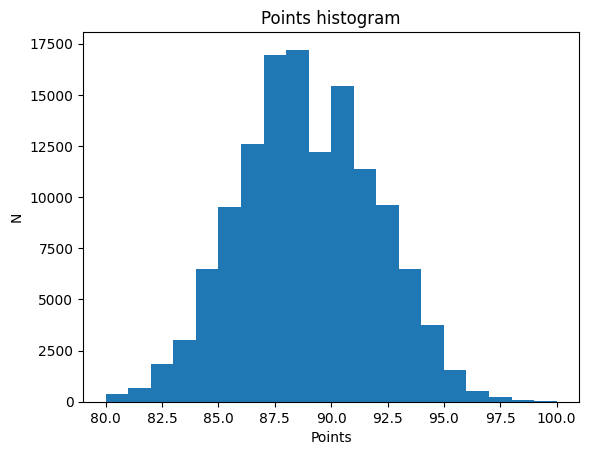

In [15]:
plt.hist(df.points,bins=20)
plt.title('Points histogram')
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [18]:
df["label"]=(df.points >= 90).astype(int)
df = df[["description","points","label"]]

In [19]:
df.tail()

,description,points,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,90,1
129967,Citation is given as much as a decade of bottl...,90,1
129968,Well-drained gravel soil gives this wine its c...,90,1
129969,"A dry style of Pinot Gris, this is crisp with ...",90,1
129970,"Big, rich and off-dry, this is powered by inte...",90,1


In [20]:
train, val, test = np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])

In [21]:
len(train),len(val),len(test)

(103976, 12997, 12998)

In [25]:
# convert each train, val, and test dataframe into a tf.data.Dataset then shuffle, and batches the data
def df_to_dataset(dataframe, shuffle=True,batch_size=1024):
    df = dataframe.copy()
    labels = df.pop('label')
    df = df["description"]
    ds = tf.data.Dataset.from_tensor_slices((df,labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(batch_size)
        #optimize using prefetch
        ds = ds.prefetch(tf.data.AUTOTUNE)
        return ds

In [26]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [27]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b'Fully oaked, and you can tell via the aromas of coconut, resin, vanilla and latex that sit on top of tobacco and floral berry scents. Feels tight and high in acid, with herbal-leaning red berry flavors. Fresh and basic on the finish, with lasting acidity.',
        b'Cinnamon-scented plums are written all over this. This was made to be smooth and mellow and the pliable, soft, plummy fruit notes achieve this wonderfully. The palate remains medium-bodied and balanced on this easy-drinnking red.',
        b'Crisp and steely, this is a bright and fruity wine. It has a tight texture cut with acidity and citrus flavors. The wine is lively, packed with fruitiness that has a delicious refreshing aftertaste. Drink from late 2017.',
        ...,
        b'Mike Dobrovic, winemaker at Mulderbosch, coaxes a blend of open rich fruit with a spine of steel from his fruit. The wine is definitely New World in style with its creamy wood flavors, 

Embedding + Model

In [28]:
#token based text embedding trained on english google news 7B corpus
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding,dtype=tf.string,trainable=True)

In [30]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.25087324, -0.01791291, -0.08144803, ..., -0.11978061,
        -0.00402558,  0.05173407],
       [ 0.40198082, -0.16350625, -0.11639608, ..., -0.03473942,
         0.0362627 ,  0.10612642],
       [ 0.6012299 ,  0.01171967,  0.22801954, ..., -0.1919781 ,
        -0.30737716,  0.14738989],
       ...,
       [ 0.3535367 , -0.02867074,  0.05869676, ..., -0.01930722,
        -0.11737341,  0.21389182],
       [ 0.35238615, -0.3942335 , -0.01421663, ...,  0.28234252,
        -0.1294897 , -0.09205665],
       [ 0.20016345, -0.00127448, -0.07438562, ..., -0.13867633,
        -0.1784233 ,  0.14346595]], dtype=float32)>

In [40]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
#drop out is add when the validation loss didnt decrease while train loss decrease in previous training
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [42]:
model.evaluate(train_data)

102/102 [==============================] - 20s 196ms/step - loss: 0.7111 - accuracy: 0.4026


[0.7110764980316162, 0.40256404876708984]

In [43]:
model.evaluate(valid_data)

13/13 [==============================] - 3s 204ms/step - loss: 0.7136 - accuracy: 0.3979


[0.7135823965072632, 0.3978610336780548]

In [44]:
history = model.fit(train_data,epochs=5,validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 142s 1s/step - loss: 0.5616 - accuracy: 0.7102 - val_loss: 0.4109 - val_accuracy: 0.8167
Epoch 2/5
102/102 [==============================] - 142s 1s/step - loss: 0.4069 - accuracy: 0.8295 - val_loss: 0.3857 - val_accuracy: 0.8249
Epoch 3/5
102/102 [==============================] - 142s 1s/step - loss: 0.3646 - accuracy: 0.8508 - val_loss: 0.3832 - val_accuracy: 0.8273
Epoch 4/5
102/102 [==============================] - 142s 1s/step - loss: 0.3436 - accuracy: 0.8597 - val_loss: 0.3851 - val_accuracy: 0.8277
Epoch 5/5
102/102 [==============================] - 141s 1s/step - loss: 0.3270 - accuracy: 0.8688 - val_loss: 0.3834 - val_accuracy: 0.8259


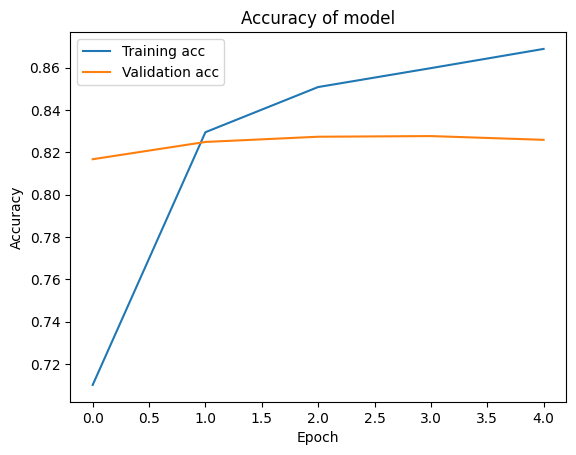

In [46]:
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'],label="Validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

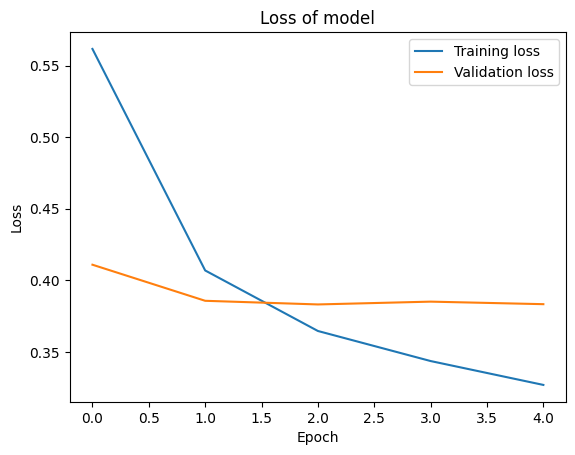

In [47]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [48]:
model.evaluate(test_data)

13/13 [==============================] - 2s 190ms/step - loss: 0.3815 - accuracy: 0.8274


[0.38146838545799255, 0.827358067035675]

#LSTM

In [50]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [51]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'to', 'it', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [54]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [55]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [56]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 4s 318ms/step - loss: 0.6944 - accuracy: 0.3782


[0.6943768262863159, 0.3781642019748688]

In [57]:
history = model.fit(train_data,epochs=5,validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 60s 527ms/step - loss: 0.5817 - accuracy: 0.6833 - val_loss: 0.4339 - val_accuracy: 0.7940
Epoch 2/5
102/102 [==============================] - 44s 428ms/step - loss: 0.3820 - accuracy: 0.8281 - val_loss: 0.3547 - val_accuracy: 0.8408
Epoch 3/5
102/102 [==============================] - 46s 452ms/step - loss: 0.3537 - accuracy: 0.8428 - val_loss: 0.3498 - val_accuracy: 0.8427
Epoch 4/5
102/102 [==============================] - 44s 427ms/step - loss: 0.3441 - accuracy: 0.8471 - val_loss: 0.3542 - val_accuracy: 0.8420
Epoch 5/5
102/102 [==============================] - 46s 451ms/step - loss: 0.3416 - accuracy: 0.8477 - val_loss: 0.3486 - val_accuracy: 0.8407


In [58]:
model.evaluate(test_data)

13/13 [==============================] - 3s 234ms/step - loss: 0.3576 - accuracy: 0.8339


[0.35756438970565796, 0.8338975310325623]